## What we need 

Get data from WRDS --> is this through openAP

get data from FRED? -- Where is this? 
get fama french factors? 

How do we get the long-short positions?? like how do we see the returns?

are we able to get wrds connection or should we get a file downloaded from you 

will we be able to use gridsearchCV to run multiple models at once?

In [1]:
DEV = True # will shrink datasets after loading


In [2]:
import pandas as pd
import polars as pl

import numpy as np

import statsmodels.formula.api as smf
import statsmodels.api as sm
from sklearn.neural_network import MLPRegressor
from sklearn.preprocessing import StandardScaler
from datetime import datetime
from ydata_profiling import ProfileReport
import matplotlib.pyplot as plt
import seaborn as sns
import os

import warnings
warnings.simplefilter(action="ignore", category=FutureWarning)

In [3]:
crsp = pd.read_csv('crsp_data.csv')
crsp.info()

# for speedy dev, pick 20 permnos at random (with seed)
if DEV:
    np.random.seed(123)
    permnos = crsp['permno'].unique()
    permnos = np.random.choice(permnos, size=20, replace=False)
    crsp = crsp[crsp['permno'].isin(permnos)]

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4047630 entries, 0 to 4047629
Data columns (total 3 columns):
 #   Column  Dtype  
---  ------  -----  
 0   permno  int64  
 1   date    object 
 2   ret     float64
dtypes: float64(1), int64(1), object(1)
memory usage: 92.6+ MB


In [4]:
# crsp = pl.from_pandas(crsp)

crsp['date'] = pd.to_datetime(crsp['date'])

cleancrsp = crsp.query('ret.notnull() and date.dt.year >= 1975')
#crsp["ret"].is_not_null(), crsp['date'].dt.year() >= 1975) 
# keep only the data that has return and after 1975

len(cleancrsp['ret'].notnull()) # check that no null values in ret
len(cleancrsp['ret'].notnull()) == len(cleancrsp) # check that all ret values are not null

cleancrsp


,permno,date,ret
29180,10181,1986-05-30,6.8493
29181,10181,1986-06-30,16.6667
29182,10181,1986-07-31,1.0989
29183,10181,1986-08-29,-6.5217
29184,10181,1986-09-30,-4.6512
...,...,...,...
4037917,93235,2014-04-30,17.2319
4037918,93235,2014-05-30,-1.3066
4037919,93235,2014-06-30,5.7683
4037920,93235,2014-07-31,-2.9951


In [5]:
max_idx = cleancrsp['ret'].argmax()

cleancrsp.iloc[max_idx-5:max_idx+5] # this seems like an outlier for sure, not to be included in the data --> company is black stone minerals. 

,permno,date,ret
1789840,42076,1975-06-30,0.0000
1789841,42076,1975-07-31,8.3333
1789842,42076,1975-08-29,0.0000
1789843,42076,1975-09-30,-15.3846
1789844,42076,1975-10-31,-9.0909
2352007,61241,1975-01-31,147.0588
2352008,61241,1975-02-28,21.4286
2352009,61241,1975-03-31,33.3333
2352010,61241,1975-04-30,2.9412
2352011,61241,1975-05-30,31.4286


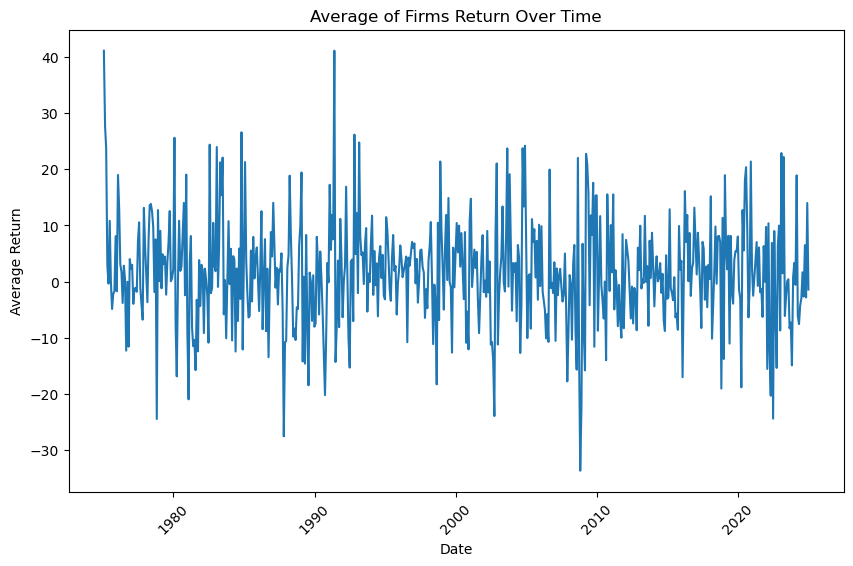

In [32]:
# Exploratory Data Analysis (EDA) on the returns data looking at the average market return per year
plt.figure(figsize=(10, 6))
sns.lineplot(data=cleancrsp, x='date', y='ret', ci=None)
plt.title('Average of Firms Return Over Time')
plt.xlabel('Date')
plt.ylabel('Average Return')
plt.xticks(rotation=45)
plt.show()


In [7]:
cleancrsp['ret'].describe(percentiles=[.01, .05, .10, .25, .5, .75, .9, .95, .99, .995]) # check the distribution of returns

count    2497.000000
mean        1.613311
std        15.738224
min       -66.573800
1%        -36.856788
5%        -21.481520
10%       -14.941300
25%        -6.060600
50%         0.539100
75%         7.337300
90%        17.835280
95%        26.547200
99%        53.333592
99.5%      63.974036
max       147.058800
Name: ret, dtype: float64

In [9]:
cleancrsp['permno'].nunique() # check the number of unique permnos

cleancrsp['permno'].value_counts()


# profile = ProfileReport(cleancrsp, title="CRSP Data Profiling Report")


permno
61241    600
78837    333
87666    297
69060    206
17340    169
90316    154
14985    122
78850    111
79404    110
77652     79
40934     72
93235     55
28338     54
10181     46
21538     38
86096     27
24482     14
42076     10
Name: count, dtype: int64

In [41]:
# profile

In [11]:
import pandas_datareader as pdr
# load Fama-French factors

start = '1975-01-01'
start_date = datetime.strptime(start, '%Y-%m-%d')

# load Fama-French 5 factors
ff_5 = pdr.get_data_famafrench('F-F_Research_Data_5_Factors_2x3', start=start_date)[0]
ff_mom = pdr.get_data_famafrench('F-F_Momentum_Factor', start=start_date)[0]

# # load Fama-French factors
# df_factors = pdr.ff.FamaFrenchReader('F-F_Research_Data_5_Factors_2x3', start='1975-01-01').read()[0]

# # add momentum to this

ff_mom.columns = ['Mom'] # rename
ff_mom
ff_factors = pd.merge(ff_5, ff_mom, left_index=True, right_index=True)
# df_factors # FYI: contains Mkt-RF and RF, but no Mkt
#


In [12]:
ff_factors = ff_factors.reset_index().rename(columns={"Mkt-RF":"mkt_excess", "Date":"date"})

ff_factors
ff_factors["date"] = ff_factors["date"].dt.to_timestamp()

ff_factors["date"] = ff_factors["date"].apply(lambda x: x.replace(day=28))

# # # Then add the month offset
ff_factors["date"] = ff_factors["date"] + pd.DateOffset(months=1)
ff_factors
## will need to lag the signals and put the date to 28

,date,mkt_excess,SMB,HML,RMW,CMA,RF,Mom
0,1975-02-28,13.66,12.91,8.28,-0.78,-0.90,0.58,-13.82
1,1975-03-28,5.56,-0.65,-4.45,1.16,-2.11,0.43,-0.61
2,1975-04-28,2.66,4.00,2.38,1.26,-1.33,0.41,-2.04
3,1975-05-28,4.23,-0.71,-1.14,1.41,-1.34,0.44,1.38
4,1975-06-28,5.19,2.89,-4.10,-0.98,-0.60,0.44,-0.58
...,...,...,...,...,...,...,...,...
595,2024-09-28,1.61,-3.65,-1.13,0.85,0.86,0.48,4.79
596,2024-10-28,1.74,-1.02,-2.59,0.04,-0.26,0.40,-0.60
597,2024-11-28,-0.97,-0.88,0.89,-1.38,1.03,0.39,2.87
598,2024-12-28,6.51,4.78,-0.05,-2.62,-2.17,0.40,0.90


## Open Signals from Zip

In [13]:
from zipfile import ZipFile


def open_dataframe_from_zip(zip_filepath, csv_filename):
    """
    Opens a Pandas DataFrame from a CSV file within a zip archive.

    Args:
        zip_filepath (str): Path to the zip file.
        csv_filename (str): Name of the CSV file inside the zip archive.

    Returns:
        pandas.DataFrame: The DataFrame read from the CSV file, or None if an error occurs.
    """
    try:
        with ZipFile(zip_filepath) as zf:
            with zf.open(csv_filename) as csvf:
                df = pd.read_csv(csvf)
        return df
    except FileNotFoundError:
        print(f"Error: Zip file not found at '{zip_filepath}'")
        return None
    except KeyError:
        print(f"Error: CSV file '{csv_filename}' not found in the zip archive.")
        return None
    except Exception as e:
        print(f"An unexpected error occurred: {e}")
        return None

# Example usage:
if DEV == False:
    zip_filepath = 'signed_predictors_dl_wide.zip'
    csv_filename = 'signed_predictors_dl_wide.csv'
    signals = open_dataframe_from_zip(zip_filepath, csv_filename)


    
# for speedy dev,
if DEV: 
    zip_filepath = 'signals.zip'
    csv_filename = 'signals.csv'
    signals = open_dataframe_from_zip(zip_filepath, csv_filename).drop(columns=['Unnamed: 0', 'Unnamed: 0.1'], axis=1) # drop the unnamed column and date column
    # signals = signals.iloc[:,:20] # only take the first 20 columns for dev

if signals is not None:
    print(signals.head())

   permno        date  yyyymm_signals  AM  AOP  AbnormalAccruals  Accruals  \
0   10000  1986-02-28          198601 NaN  NaN               NaN       NaN   
1   10000  1986-03-28          198602 NaN  NaN               NaN       NaN   
2   10000  1986-04-28          198603 NaN  NaN               NaN       NaN   
3   10000  1986-05-28          198604 NaN  NaN               NaN       NaN   
4   10000  1986-06-28          198605 NaN  NaN               NaN       NaN   

   AccrualsBM  Activism1  Activism2  ...  AgeIPO  AnalystRevision  \
0         NaN        NaN        NaN  ...     NaN              NaN   
1         NaN        NaN        NaN  ...     NaN              NaN   
2         NaN        NaN        NaN  ...     NaN              NaN   
3         NaN        NaN        NaN  ...     NaN              NaN   
4         NaN        NaN        NaN  ...     NaN              NaN   

   AnalystValue  AnnouncementReturn  AssetGrowth  BM  BMdec  BPEBM  Beta  \
0           NaN                 NaN     

In [9]:
signals.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5273600 entries, 0 to 5273599
Data columns (total 21 columns):
 #   Column              Dtype  
---  ------              -----  
 0   permno              int64  
 1   date                object 
 2   yyyymm_signals      int64  
 3   AM                  float64
 4   AOP                 float64
 5   AbnormalAccruals    float64
 6   Accruals            float64
 7   AccrualsBM          float64
 8   Activism1           float64
 9   Activism2           float64
 10  AdExp               float64
 11  AgeIPO              float64
 12  AnalystRevision     float64
 13  AnalystValue        float64
 14  AnnouncementReturn  float64
 15  AssetGrowth         float64
 16  BM                  float64
 17  BMdec               float64
 18  BPEBM               float64
 19  Beta                float64
 20  BetaFP              float64
dtypes: float64(18), int64(2), object(1)
memory usage: 844.9+ MB


In [24]:


# signals.to_csv('signals.csv')

# ## want to make this a zip file to push
# with ZipFile('signals.zip', 'w') as zf:
#     zf.write('signals.csv')

In [14]:
def move_column_to_front(df, columns):
    return df[columns + [col for col in df.columns if col not in columns]]  




In [15]:

signals = signals.rename(columns={'yyyymm': 'yyyymm_signals'})


    # Create date that is one month ahead for merging with returns
signals["yyyymm_signals"] = signals["yyyymm_signals"].astype(str) 
signals["date"] = pd.to_datetime(signals["yyyymm_signals"] + "28", format="%Y%m%d") + pd.DateOffset(months=1)




In [16]:
signals = move_column_to_front(signals, ['permno', 'date']) # lag signals by a month

signals.head()

,permno,date,yyyymm_signals,AM,AOP,AbnormalAccruals,Accruals,AccrualsBM,Activism1,Activism2,...,AgeIPO,AnalystRevision,AnalystValue,AnnouncementReturn,AssetGrowth,BM,BMdec,BPEBM,Beta,BetaFP
0,10000,1986-02-28,198601,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,10000,1986-03-28,198602,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,10000,1986-04-28,198603,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,10000,1986-05-28,198604,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,10000,1986-06-28,198605,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [17]:


# create a new datetime column, use the year and month, but make the date 28th of the month:
cleancrsp['date'] = pd.to_datetime(cleancrsp['date'].dt.year*100 + cleancrsp['date'].dt.month, format='%Y%m') + pd.DateOffset(days=27)


/var/folders/2m/j1mxfjpd7pl5zmd8sqqqcn_m0000gn/T/ipykernel_7169/2183361064.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cleancrsp['date'] = pd.to_datetime(cleancrsp['date'].dt.year*100 + cleancrsp['date'].dt.month, format='%Y%m') + pd.DateOffset(days=27)


## Need to Convert yyyymm column to yyyy-mm-dd datetime column, rename to date

Something interesting, the crsp dataset uses trading days. How do we get this in our signals dataset. Just go off year-months?

Can we merge on yyyy-mm and not include dd so that we can match the crsp dates? But how would it know the date in the future? For instance, would it know the end of the month a year from now, or guess based on the previous crsp dd for that year or month before?

Is lagging the signals the right thing to do or do I lag the returns??


value weighting 


In [21]:
bigdata = cleancrsp.merge(signals, on=['permno', 'date'], how='left', indicator=True, validate="one_to_one") 
bigdata

,permno,date,ret,yyyymm_signals,AM,AOP,AbnormalAccruals,Accruals,AccrualsBM,Activism1,...,AnalystRevision,AnalystValue,AnnouncementReturn,AssetGrowth,BM,BMdec,BPEBM,Beta,BetaFP,_merge
0,10181,1986-05-28,6.8493,198604,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,both
1,10181,1986-06-28,16.6667,198605,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,both
2,10181,1986-07-28,1.0989,198606,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,both
3,10181,1986-08-28,-6.5217,198607,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,both
4,10181,1986-09-28,-4.6512,198608,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,both
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2492,93235,2014-04-28,17.2319,201403,5.169856,NaN,NaN,-0.016947,NaN,NaN,...,NaN,NaN,-0.027726,0.026716,-0.046185,0.942494,-0.000611,0.087931,0.144612,both
2493,93235,2014-05-28,-1.3066,201404,4.409937,NaN,NaN,-0.016947,NaN,NaN,...,NaN,NaN,-0.027726,0.026716,-0.046185,0.942494,-0.002689,0.029387,0.193669,both
2494,93235,2014-06-28,5.7683,201405,4.468319,NaN,NaN,-0.016947,NaN,NaN,...,NaN,NaN,0.008933,0.026716,-0.046185,0.942494,-0.002556,0.031067,0.210866,both
2495,93235,2014-07-28,-2.9951,201406,4.224629,NaN,NaN,-0.016947,NaN,NaN,...,NaN,NaN,NaN,0.026716,-0.046185,0.970233,-0.003080,0.042468,0.240028,both


In [22]:
bigdata = bigdata.merge(ff_factors, on='date', how='left', validate="many_to_one") # merge with Fama-French factors
bigdata

,permno,date,ret,yyyymm_signals,AM,AOP,AbnormalAccruals,Accruals,AccrualsBM,Activism1,...,Beta,BetaFP,_merge,mkt_excess,SMB,HML,RMW,CMA,RF,Mom
0,10181,1986-05-28,6.8493,198604,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,both,-1.31,2.84,-2.87,2.91,0.03,0.52,-0.37
1,10181,1986-06-28,16.6667,198605,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,both,4.62,-1.29,-0.21,2.13,1.08,0.49,2.05
2,10181,1986-07-28,1.0989,198606,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,both,1.03,-0.89,1.28,1.80,0.87,0.52,5.07
3,10181,1986-08-28,-6.5217,198607,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,both,-6.45,-3.46,4.70,-0.54,0.84,0.52,1.83
4,10181,1986-09-28,-4.6512,198608,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,both,6.07,-4.35,3.51,-1.66,3.21,0.46,-5.28
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2492,93235,2014-04-28,17.2319,201403,5.169856,NaN,NaN,-0.016947,NaN,NaN,...,0.087931,0.144612,both,0.43,-1.08,4.93,2.13,1.92,0.00,-3.29
2493,93235,2014-05-28,-1.3066,201404,4.409937,NaN,NaN,-0.016947,NaN,NaN,...,0.029387,0.193669,both,-0.19,-4.11,1.17,3.47,1.00,0.00,-3.89
2494,93235,2014-06-28,5.7683,201405,4.468319,NaN,NaN,-0.016947,NaN,NaN,...,0.031067,0.210866,both,2.06,-1.89,-0.13,0.06,-1.00,0.00,0.87
2495,93235,2014-07-28,-2.9951,201406,4.224629,NaN,NaN,-0.016947,NaN,NaN,...,0.042468,0.240028,both,2.61,3.10,-0.70,-1.88,-2.00,0.00,0.69


In [23]:
bigdata.columns[-7:]

Index(['mkt_excess', 'SMB', 'HML', 'RMW', 'CMA', 'RF', 'Mom'], dtype='object')

In [24]:
#combine

signal_list = bigdata.columns[3:] 

bigdata[signal_list].describe()

,AM,AOP,AbnormalAccruals,Accruals,AccrualsBM,Activism1,Activism2,AdExp,AgeIPO,AnalystRevision,...,BPEBM,Beta,BetaFP,mkt_excess,SMB,HML,RMW,CMA,RF,Mom
count,1704.000000,816.000000,1369.000000,1596.000000,265.000000,107.000000,11.000000,800.000000,256.000000,1563.000000,...,1704.000000,2201.000000,1987.000000,2492.000000,2492.000000,2492.000000,2492.000000,2492.000000,2492.000000,2492.000000
mean,3.135168,-2.559536,-0.002498,0.036187,0.298113,16.785047,11.931496,0.024550,31.500000,1.019391,...,-0.306544,1.171452,1.188292,0.762071,0.183471,0.271176,0.358359,0.257789,0.369807,0.618355
std,4.035629,4.657140,0.093481,0.103379,0.458295,1.189800,0.730371,0.042113,34.790465,1.106479,...,5.422417,0.733839,0.775232,4.506603,3.061735,3.128726,2.386691,2.071090,0.278721,4.288512
min,0.044649,-26.619371,-0.378753,-0.587368,0.000000,16.000000,9.738513,0.001219,0.000000,-9.571428,...,-109.735120,-0.419286,0.002696,-23.240000,-15.320000,-13.880000,-18.650000,-7.200000,0.000000,-34.300000
25%,0.707649,-2.447555,-0.053532,-0.019085,0.000000,16.000000,12.057259,0.005964,5.000000,0.980279,...,-0.412697,0.584052,0.567406,-1.920000,-1.540000,-1.540000,-0.760000,-1.000000,0.137500,-0.910000
50%,1.432095,-0.683316,-0.006319,0.042289,0.000000,16.000000,12.159690,0.011564,10.000000,1.000000,...,-0.031030,1.138633,1.084799,1.170000,0.070000,0.140000,0.300000,0.090000,0.390000,0.630000
75%,4.485829,-0.119619,0.054627,0.093920,1.000000,17.000000,12.202278,0.024305,60.250000,1.018167,...,0.032379,1.638533,1.714993,3.650000,1.920000,1.750000,1.360000,1.420000,0.490000,2.850000
max,26.594208,1.398652,0.286598,0.285369,1.000000,20.000000,12.250266,0.422114,102.000000,20.250000,...,66.705109,3.400727,3.841151,13.660000,18.280000,12.800000,13.070000,9.070000,1.350000,18.200000


In [25]:
# pretend its a dataframe grab the rows where the column is the name and make that a list

signal_documentation = pd.read_csv('SignalDoc.csv')
signal_documentation

# need to find a way to add the column type from cat. form to match the acronyms which are the columns of the dataset
signaldoc = signal_documentation[['Acronym', 'Cat.Form']].drop_duplicates()
signaldoc


,Acronym,Cat.Form
0,AbnormalAccruals,continuous
1,Accruals,continuous
2,AccrualsBM,discrete
3,Activism1,continuous
4,AM,continuous
...,...,...
326,SP_q,continuous
327,tang_q,continuous
328,Tax_q,continuous
329,WW_Q,continuous


In [26]:

from sklearn.preprocessing import OneHotEncoder 
from sklearn.compose import ColumnTransformer, make_column_selector
from sklearn.linear_model import LogisticRegression, Ridge, Lasso, LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, HistGradientBoostingRegressor
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.impute import SimpleImputer
from df_after_transform import df_after_transform
from sklearn.model_selection import KFold, cross_validate, GridSearchCV, cross_val_score


In [27]:
## First We need to split the data into train and test sets
## Don't use train, test, split

X = bigdata.drop(columns=['ret']) # drop the columns that are not needed
y = bigdata['ret'] # target variable

# split_date = '1990-12-28'

# train_data = X[X['date'] <= split_date]
# test_data = X[X['date'] > split_date]

# train_data = train_data.drop(columns=['yyyymm_signals', 'permno', '_merge']) # drop the columns that are not needed
# test_data = test_data.drop(columns=['yyyymm_signals', 'permno', '_merge']) # drop the columns that are not needed
# # check the number of rows in train and test data
# print(f"Train data shape: {train_data.shape}")
# print(f"Test data shape: {test_data.shape}")



In [38]:
# Split the data into train and test sets based on date
X_train = X[X['date'] <= '1980-12-28']
X_test = X[(X['date'] > '1980-12-28') & (X['date'] <= '1981-12-28')]
y_train = y[X['date'] <= '1980-12-28']
y_test = y[(X['date'] > '1980-12-28') & (X['date'] <= '1981-12-28')]

In [ ]:
## create rolling window function that creates a rolling window of 12 months for the data to predict the next month return
def rolling_window(df, window=12):
    """
    Create a rolling window of the specified size for the DataFrame.
    
    Args:
        df (pd.DataFrame): The DataFrame to create a rolling window for.
        window (int): The size of the rolling window.
        
    Returns:
        pd.DataFrame: A DataFrame with the rolling window applied.
    """
    return df.rolling(window=window, min_periods=1).mean().shift(1)  # Shift to avoid lookahead bias
# Apply rolling window to the features  


In [28]:
from sklearn.linear_model import RidgeCV

exclude = ['ret', 'yyyymm_signals', 'permno'] # columns to exclude from the preprocessing pipe

continuous_cols = signaldoc.loc[signaldoc['Cat.Form'] == 'continuous', 'Acronym'].tolist() + ['mkt_excess', 'SMB', 'HML', 'RMW', 'CMA', 'Mom'] # convert df to list to get columns for preprocessing pipe
# 'Mkt-RF', 'SMB', 'HML', 'RMW', 'CMA', 'Mom' are the Five Fama-French factors and momentum factor
discrete_cols = signaldoc.loc[signaldoc['Cat.Form'] == 'discrete', 'Acronym'].tolist() # convert df to list to get columns for preprocessing pipe

continuous_cols = [col for col in continuous_cols if col in X.columns and col not in exclude] # filter out columns that are not in X
discrete_cols = [col for col in discrete_cols if col in X.columns and col not in exclude] # filter out columns that are not in X

numer_pipe = make_pipeline(SimpleImputer(strategy='mean'),
                           StandardScaler()) 

cat_pipe   = make_pipeline(SimpleImputer(strategy='most_frequent'), OneHotEncoder(handle_unknown='ignore')) # drop first to avoid dummy variable trap


preproc_pipe = ColumnTransformer(
    transformers=[
        ('numbers', numer_pipe, continuous_cols),  
        ('categoricals', cat_pipe, discrete_cols), 
    ],
    remainder='drop'  
)

model_pipe = make_pipeline(
    preproc_pipe,
    RidgeCV()
)

from df_after_transform import df_after_transform

preproc_df = df_after_transform(preproc_pipe,X)


# model_pipe.fit(,



In [45]:
preproc_df = df_after_transform(preproc_pipe,X)
print(f'There are {preproc_df.shape[1]} columns in the preprocessed data.')
preproc_df.describe().T.round(2)

There are 25 columns in the preprocessed data.


,count,mean,std,min,25%,50%,75%,max
AbnormalAccruals,2497.0,-0.00,1.00,-5.44,-0.09,-0.00,0.03,4.18
Accruals,2497.0,0.00,1.00,-7.55,-0.26,0.00,0.36,3.02
Activism1,2497.0,-0.00,1.00,-3.20,0.00,0.00,0.00,13.11
AM,2497.0,-0.00,1.00,-0.93,-0.66,-0.00,-0.00,7.04
AnalystRevision,2497.0,0.00,1.00,-12.10,-0.02,0.00,0.00,21.97
AnnouncementReturn,2497.0,0.00,1.00,-7.38,-0.22,-0.00,0.25,6.77
AssetGrowth,2497.0,-0.00,1.00,-11.94,-0.06,0.00,0.32,2.81
BM,2497.0,0.00,1.00,-5.00,-0.07,0.00,0.36,2.49
BMdec,2497.0,0.00,1.00,-1.37,-0.51,0.00,0.00,7.20
BPEBM,2497.0,-0.00,1.00,-24.44,-0.00,-0.00,0.07,14.96


In [29]:
gridsearch = GridSearchCV(
    model_pipe,
    param_grid={
        'ridgecv__alphas': [1e-3, 1e-2, 1e-1, 1, 10, 100]
    },
    cv=5,
    scoring='r2',
    verbose=1,
    n_jobs=-1
)


In [39]:
gridsearch.fit(X_train, y_train)

Fitting 5 folds for each of 6 candidates, totalling 30 fits


/opt/anaconda3/lib/python3.12/site-packages/sklearn/impute/_base.py:598: UserWarning: Skipping features without any observed values: ['Activism1' 'Activism2' 'AgeIPO']. At least one non-missing value is needed for imputation with strategy='mean'.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/impute/_base.py:598: UserWarning: Skipping features without any observed values: ['Activism1' 'Activism2' 'AgeIPO']. At least one non-missing value is needed for imputation with strategy='mean'.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/impute/_base.py:598: UserWarning: Skipping features without any observed values: ['Activism1' 'Activism2' 'AgeIPO']. At least one non-missing value is needed for imputation with strategy='mean'.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/impute/_base.py:598: UserWarning: Skipping features without any observed values: ['Activism1' 'Activism2' 'AgeIPO']. At least one non-missing value is neede

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('columntransformer',
                                        ColumnTransformer(transformers=[('numbers',
                                                                         Pipeline(steps=[('simpleimputer',
                                                                                          SimpleImputer()),
                                                                                         ('standardscaler',
                                                                                          StandardScaler())]),
                                                                         ['AbnormalAccruals',
                                                                          'Accruals',
                                                                          'Activism1',
                                                                          'AM',
                                                                          'AnalystRevision',
                                                                          'AnnouncementReturn',
                                                                          'AssetGrowth',
                                                                          'BM',
                                                                          'BMdec',
                                                                          'BPEBM',
                                                                          'Activism2',
                                                                          'AdExp',
                                                                          'AgeIPO',
                                                                          'An...,
                                                                          'AOP',
                                                                          'Beta',
                                                                          'BetaFP',
                                                                          'mkt_excess',
                                                                          'SMB',
                                                                          'HML',
                                                                          'RMW',
                                                                          'CMA',
                                                                          'Mom']),
                                                                        ('categoricals',
                                                                         Pipeline(steps=[('simpleimputer',
                                                                                          SimpleImputer(strategy='most_frequent')),
                                                                                         ('onehotencoder',
                                                                                          OneHotEncoder(handle_unknown='ignore'))]),
                                                                         ['AccrualsBM'])])),
                                       ('ridgecv', RidgeCV())]),
             n_jobs=-1,
             param_grid={'ridgecv__alphas': [0.001, 0.01, 0.1, 1, 10, 100]},
             scoring='r2', verbose=1)

In [40]:
print(f'Best parameters: {gridsearch.best_params_}')
print(f'Best cross-validated R^2 score: {gridsearch.best_score_:.4f}')

Best parameters: {'ridgecv__alphas': 100}
Best cross-validated R^2 score: -0.0221


In [39]:

# Assuming your dataframe is called 'returns_df' with a 'Date' column
# and is already sorted by date

def rolling_validation(df, feature_cols, target_col, 
                       train_window=12, test_window=1, 
                       model_func=None):
    """
    Perform rolling window validation.
    
    Parameters:
    - df: DataFrame with time-series data
    - feature_cols: List of column names for features
    - target_col: Column name for target variable
    - train_window: Number of periods for training (e.g., 12 months)
    - test_window: Number of periods for testing (e.g., 1 month)
    - model_func: Function that takes X_train, y_train and returns a fitted model
    
    Returns:
    - Dictionary with performance metrics
    """
    results = {
        'dates': [],
        'r2': [],
        'predictions': [],
        'actuals': []
    }
    
    # Get the unique dates in your dataset
    dates = df['date'].unique()
    
    
    # Make sure we have enough data for at least one validation cycle
    if len(dates) < train_window + test_window:
        raise ValueError("Not enough time periods for specified windows")
    
    # Loop through time periods for rolling validation
    for i in range(len(dates) - train_window - test_window + 1):
        # Define training and testing periods
        train_start = i
        train_end = i + train_window
        test_start = train_end
        test_end = test_start + test_window
        
        train_dates = dates[train_start:train_end]
        test_dates = dates[test_start:test_end]
        
        # Get training and testing data
        train_mask = df['date'].isin(train_dates)
        test_mask = df['date'].isin(test_dates)
        
        X_train = df.loc[train_mask, feature_cols]
        y_train = df.loc[train_mask, target_col]
        X_test = df.loc[test_mask, feature_cols]
        y_test = df.loc[test_mask, target_col]
        
        # Train model
        model = model_func(X_train, y_train)
        
        # Make predictions
        y_pred = model.predict(X_test)
        
        # Calculate metrics
        r2 = r2_score(y_test, y_pred)
       
        
        # Store results
        results['dates'].append(test_dates[-1])
        results['r2'].append(r2)
 
        results['predictions'].extend(y_pred)
        results['actuals'].extend(y_test)
        
    return results

# Example usage
def train_model(X, y):
    # Replace this with your actual model
    #import MLPRegressor
    from sklearn.neural_network import MLPRegressor
    
    # Using a Multi-layer Perceptron Regressor as an example
    # Adjust the parameters based on your specific needs

    model = MLPRegressor(
        hidden_layer_sizes=(32, 16, 8),  # Increase neurons for more learning capacity
        activation="relu",  # Good for nonlinear relationships
        solver="adam",  # Robust optimizer for noisy data
        alpha=0.001,  # Add regularization to reduce overfitting
        batch_size=10000,
        learning_rate_init=0.01,  # Lower learning rate for finer optimization
        max_iter=100,  # Allow more iterations for convergence
        early_stopping=True,  # Stop training if validation error doesn't improve
        n_iter_no_change=5,  # Patience for early stopping
        random_state=1,  # Ensure reproducibility
        )
    model.fit(X, y)
    return model

# Define your feature columns and target
feature_cols = preproc_df.columns.to_list()  # Your features
target_col = ['ret']  # Your target

# Run rolling validation
results = rolling_validation(bigdata, feature_cols, target_col, 
                            train_window=12, test_window=1, 
                            model_func=train_model)

# Visualize the results
plt.figure(figsize=(12, 6))
plt.plot(results['dates'], results['r2'], label='R² Score')
plt.title('Rolling Validation Performance')
plt.xlabel('Test Period End Date')
plt.ylabel('R² Score')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

KeyError: "['AccrualsBM_0.0', 'AccrualsBM_1.0', 'AccrualsBM_nan'] not in index"

In [ ]:
# Generate cleaned data with all of the preprocessing tools above
# preproc_pipe.fit(bigdata[for signal in signal_list if signal in bigdata], bigdata['ret'])

## get the proper columns for the model
X = bigdata[signal_list]


,AM,AOP,AbnormalAccruals,Accruals,AccrualsBM,Activism1,Activism2,AdExp,AgeIPO,AnalystRevision,AnalystValue,AnnouncementReturn,AssetGrowth,BM,BMdec,BPEBM,Beta,BetaFP
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2492,5.169856,NaN,NaN,-0.016947,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.027726,0.026716,-0.046185,0.942494,-0.000611,0.087931,0.144612
2493,4.409937,NaN,NaN,-0.016947,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.027726,0.026716,-0.046185,0.942494,-0.002689,0.029387,0.193669
2494,4.468319,NaN,NaN,-0.016947,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.008933,0.026716,-0.046185,0.942494,-0.002556,0.031067,0.210866
2495,4.224629,NaN,NaN,-0.016947,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.026716,-0.046185,0.970233,-0.003080,0.042468,0.240028


# OLS -- ML Style Portfolios

In [ ]:
fit_start = 1975
fit_end = 1990

## Want to find a better way to split and test the model
n_portfolios = 5



In [37]:
signal_list

Index(['yyyymm_signals', 'AM', 'AOP', 'AbnormalAccruals', 'Accruals',
       'AccrualsBM', 'Activism1', 'Activism2', 'AdExp', 'AgeIPO',
       'AnalystRevision', 'AnalystValue', 'AnnouncementReturn', 'AssetGrowth',
       'BM', 'BMdec', 'BPEBM', 'Beta', 'BetaFP'],
      dtype='object')